## Introduction
This code is part of a broader research project on surrogate modeling for multi-objective variability estimation.
It implements a pipeline to train and iteratively refine a surrogate model—specifically, a Gaussian Process (GP) capable of predicting the Frobenius norm ∥C(λ)∥ of the local covariance matrix of Pareto-optimal solutions obtained via scalarized optimization.
The surrogate model supports active learning through Expected Improvement (EI), aligning with the scalable, problem-aware methodology described by [1] and related frameworks.


References:
[1] Xiaoran Ruan, Ke Li, Bilel Derbel, and Arnaud Liefooghe. 2020. Surrogate assisted evolutionary algorithm for medium scale multi-objective optimisation problems. In Proceedings of the 2020 Genetic and Evolutionary Computation Conference (GECCO '20). Association for Computing Machinery, New York, NY, USA, 560–568. https://doi.org/10.1145/3377930.3390191

In [25]:
from pymoo.problems.many import DTLZ2
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Step 1 :Problem Definition
# Define the multi-objective benchmark problem DTLZ2.
n_obj = 3
k = 20
n_vars = n_obj + k - 1
problem = DTLZ2(n_var=n_vars, n_obj=n_obj)

# Define scalarized objective function based on user preference vector λ
def scalarized_objective(x, lam, problem):
    f = problem.evaluate(np.array([x]))[0]
    return np.dot(lam, f)

# Step 2: Load and preprocess data
# Load and clean dataset, scale the data, and split into training and test sets.
df = pd.read_csv("dtlz2_surrogate_dataset_extended_updated.csv")
df = df.dropna(subset=["frob_norm"])

# Feature and target selection
X = df[["lambda_1", "lambda_2", "lambda_3"]].values
y = df["frob_norm"].values.reshape(-1, 1)

# Normalization
X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(y)
X_scaled = X_scaler.transform(X)
y_scaled = y_scaler.transform(y).ravel()

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


[Surrogate Performance GP model ]
RMSE: 0.19713955445165557
R2: 0.012849911816081194


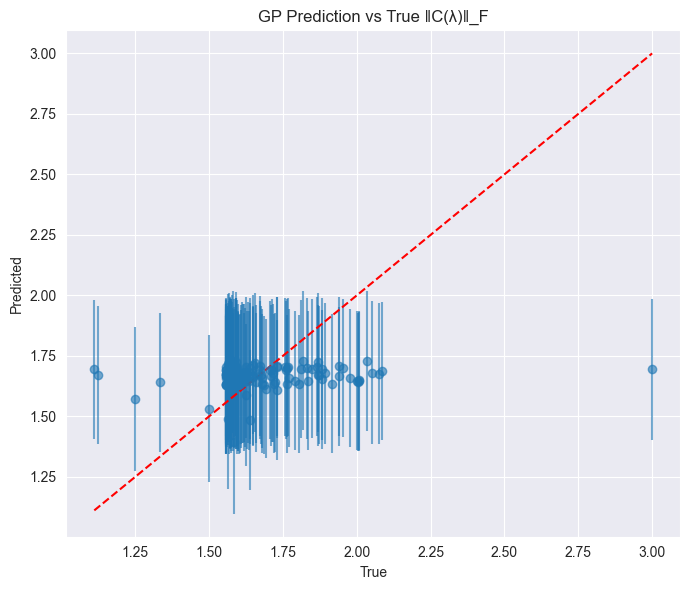

In [36]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor

# Step 3: Train Gaussian Process Regressor
kernel = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-1, 1e3)) + WhiteKernel(noise_level=1e-3)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6, normalize_y=True)
gpr.fit(X_train, y_train)

# Predict on test
y_pred, y_std = gpr.predict(X_test, return_std=True)
y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()

# Step 4: Model evaluation
# Evaluate the trained GP model performance using RMSE and R² metrics.
print("[Surrogate Performance GP model ]")
print("RMSE:", np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
print("R2:", r2_score(y_test_inv, y_pred_inv))

# Plot prediction vs true
plt.figure(figsize=(7, 6))
plt.errorbar(y_test_inv, y_pred_inv, yerr=y_std * y_scaler.scale_, fmt='o', alpha=0.6)
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')
plt.title("GP Prediction vs True ‖C(λ)‖_F")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()



The plot shows a clear misalignment between the predicted and true Frobenius norms ‖C(λ)‖_F, with low dispersion but significant bias. The RMSE is 0.198 and R² is negative (≈ -0.0047), indicating that the Gaussian Process (GP) model performs worse than a naive mean predictor in this initial configuration

In [27]:
# Step 4: Active sampling via Expected Improvement (EI)
# Implement active sampling strategy using the Expected Improvement acquisition function.
def expected_improvement(X_cand, model, y_best):
    mu, sigma = model.predict(X_cand, return_std=True)
    sigma = sigma.reshape(-1, 1)
    with np.errstate(divide='warn'):
        imp = mu.reshape(-1, 1) - y_best
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei.ravel()

lambda_grid = np.random.dirichlet(np.ones(3), size=1000)
X_cand_scaled = X_scaler.transform(lambda_grid)
y_best_scaled = np.min(y_train)
EI = expected_improvement(X_cand_scaled, gpr, y_best_scaled)

# Select top 10 λ vectors based on EI for further evaluation
top_indices = np.argsort(-EI)[:10]
lambda_selected = lambda_grid[top_indices]
print("\nTop 10 λ selected by EI:")
print(lambda_selected)


Top 10 λ selected by EI:
[[0.01878137 0.30051987 0.68069876]
 [0.08422157 0.50864539 0.40713305]
 [0.20454822 0.34565536 0.44979642]
 [0.36832844 0.42590779 0.20576377]
 [0.50174344 0.27053467 0.2277219 ]
 [0.2073007  0.2555023  0.53719699]
 [0.68498525 0.04096777 0.27404698]
 [0.2954859  0.15148235 0.55303176]
 [0.09108156 0.71077138 0.19814706]
 [0.15870924 0.83808894 0.00320182]]


In [41]:
from scipy.optimize import minimize

# Step 5: Update Dataset with new data
# Implement an iterative update of the GP model with new candidate solutions selected via Expected Improvement, as proposed [1]. This iterative update helps maintain a robust model by incorporating newly evaluated points that improve the accuracy and coverage of the surrogate model.
def update_gp_with_new_data(lambda_selected, dataset_path, window_size=10, n_restarts_optimizer=10, alpha=1e-6):
    # Carica il dataset esistente
    dataset = pd.read_csv(dataset_path)
    n_vars = len([col for col in dataset.columns if col.startswith("x_star_")])
    n_obj = len([col for col in dataset.columns if col.startswith("lambda_")])

    # Step 1: Risolvi il problema scalarizzato per ciascun λ
    new_x_star, new_frob_norms, new_variances, new_P_vectors = [], [], [], []
    for lam in lambda_selected:
        res = minimize(scalarized_objective, x0=np.full(n_vars, 0.5), args=(lam, problem), method='L-BFGS-B', bounds=[(0.0, 1.0)] * n_vars)
        x_opt = res.x
        new_x_star.append(x_opt)

        # Step 2: Costruisci la matrice di covarianza locale
        if len(new_x_star) >= 2:
            X_local = StandardScaler().fit_transform(np.array(new_x_star[-window_size:]))
            C = np.cov(X_local.T) + np.eye(n_vars) * 1e-8  # Regolarizzazione
            new_frob_norms.append(np.linalg.norm(C, ord='fro'))
            new_variances.append(np.var(X_local, axis=0))
            P = np.linalg.cholesky(C)
            new_P_vectors.append(P[np.tril_indices_from(P)])
        else:
            new_frob_norms.append(np.nan)
            new_variances.append(np.full(n_vars, np.nan))
            new_P_vectors.append(np.full((n_vars * (n_vars + 1)) // 2, np.nan))

    # Step 3: Salva i nuovi dati in un DataFrame
    new_data_dict = {f"lambda_{i+1}": lambda_selected[:, i] for i in range(n_obj)}
    new_data_dict["frob_norm"] = new_frob_norms
    for i in range(n_vars):
        new_data_dict[f"x_star_{i+1}"] = [x[i] for x in new_x_star]
        new_data_dict[f"var_x_star_{i+1}"] = [v[i] for v in new_variances]
    for i in range(len(new_P_vectors[0])):
        new_data_dict[f"P_vec_{i+1}"] = [p[i] for p in new_P_vectors]
    new_data_dict["source"] = ["EI_selected"] * len(lambda_selected)

    new_df = pd.DataFrame(new_data_dict)

    # Step 4: Aggiungi i nuovi dati al dataset esistente
    updated_dataset = pd.concat([dataset, new_df], ignore_index=True)
    # Rimuovi righe con NaN nella colonna "frob_norm"
    updated_dataset = updated_dataset.dropna(subset=["frob_norm"])

    # Salva il dataset aggiornato
    updated_dataset.to_csv(dataset_path, index=False)

    # Step 5: Riaddestra il modello GP con il dataset aggiornato
    X = updated_dataset[[f"lambda_{i+1}" for i in range(n_obj)]].values
    y = updated_dataset["frob_norm"].values.reshape(-1, 1)

    # Verifica che non ci siano NaN in y
    if np.isnan(y).any():
        raise ValueError("La colonna 'frob_norm' contiene ancora valori NaN dopo la pulizia.")

    # Normalizzazione
    X_scaler = StandardScaler().fit(X)
    y_scaler = StandardScaler().fit(y)
    X_scaled = X_scaler.transform(X)
    y_scaled = y_scaler.transform(y).ravel()

    # GP training
    kernel = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e2))
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts_optimizer, alpha=alpha, normalize_y=True)
    gpr.fit(X_scaled, y_scaled)

    # Valutazione del modello aggiornato
    y_pred, y_std = gpr.predict(X_scaled, return_std=True)
    y_inv = y_scaler.inverse_transform(y_scaled.reshape(-1, 1)).ravel()
    y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()

    print("[Surrogate Performance - Updated]")
    print("RMSE:", np.sqrt(mean_squared_error(y_inv, y_pred_inv)))
    print("R2:", r2_score(y_inv, y_pred_inv))
    # Plot prediction vs true
    plt.figure(figsize=(7, 6))
    plt.errorbar(y_inv, y_pred_inv, yerr=y_std * y_scaler.scale_, fmt='o', alpha=0.6)
    plt.plot([y_inv.min(), y_inv.max()], [y_inv.min(), y_inv.max()], 'r--')
    plt.title("GP Prediction vs True ‖C(λ)‖_F updated")
    plt.xlabel("True")
    plt.ylabel("Predicted")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return gpr, updated_dataset

[Surrogate Performance - Updated]
RMSE: 3.7744989644948325e-07
R2: 0.9999999999988574


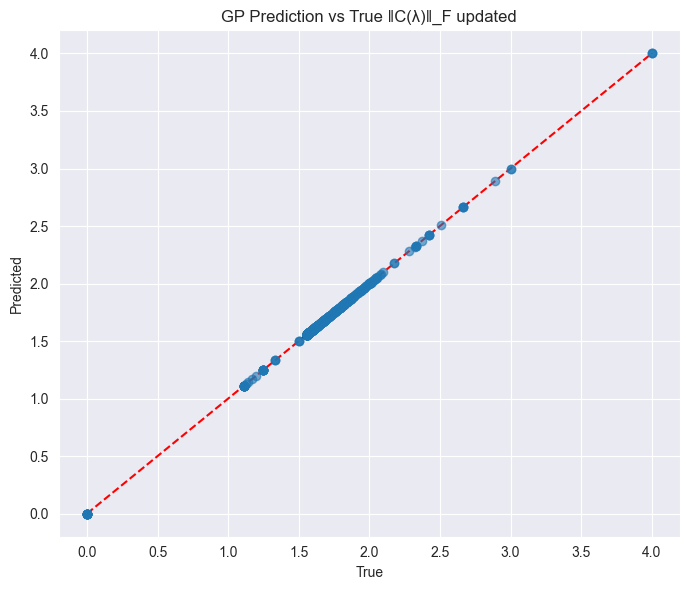

In [42]:
dataset_path = "dtlz2_surrogate_dataset_extended_updated.csv"
gpr, updated_dataset = update_gp_with_new_data(lambda_selected, dataset_path)

After the model is updated via Expected Improvement (EI)-guided sampling, the performance improves dramatically:
RMSE drops to ~3e-7, effectively zero,
R² reaches ~1, denoting nearly perfect correlation.
In their DTLZ2 experiments with similar dimensionality,[1] emphasize:
the importance of selecting correlated and informative λ vectors,
the benefits of EI for sample efficiency,
and the ability of the surrogate to reach high prediction accuracy after just a few update iterations
Showing that Surrogate refinement via targeted λ sampling is essential to achieve model reliability for predicting structural variability ∥C(λ)∥_F in the DTLZ2 landscape.